In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path # Finding CSV file path
%pip install seaborn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('./'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Using the price and other important data such as age of listing, bathroom and bedroom count, and square feet, I must determine the price or price range of a house in Marco Island. I will be using RSME as the main performance measure, but other measures will be taken into account.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

I got the data off Zillow using a chrome extension called Zillow Data Exporter and used it to manually export each page of the listings from Marco Island. Then, I used the code below to combine the data into one file.

In [2]:
# #Combining the csv files of data
# import os

# csvs = [file for file in os.listdir('data/unmerged') if file.endswith('.csv')]

# result_df = pd.concat([pd.read_csv(f'data/unmerged/{file}') for file in csvs])
# result_df.drop_duplicates()

# result_df.to_csv('house_pricing.csv', encoding='utf-8', index=False)

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

In [3]:
# The first thing I wanted to do was look at what values were full and which ones I would have to deal with in some way.
housing = pd.read_csv(Path("data/house_pricing.csv"))
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Property URL                      636 non-null    object 
 1   MLS ID                            0 non-null      float64
 2   Listing description               636 non-null    object 
 3   Property type                     636 non-null    object 
 4   Number of days on Zillow          636 non-null    int64  
 5   Property price (USD)              636 non-null    int64  
 6   Price was cut                     636 non-null    object 
 7   Price cut amount (USD)            300 non-null    float64
 8   Price cut date (MM/DD/YYYY)       300 non-null    object 
 9   Living area                       536 non-null    float64
 10  Living area unit                  536 non-null    object 
 11  Price per living area unit (USD)  536 non-null    float64
 12  Lot/land

There is a lot of property without important info such as bedroom and bathroom count as well as living area.

In [4]:
# Checking for duplicates
housing["Property URL"].value_counts()

Property URL
https://www.zillow.com/homedetails/320-Seaview-Ct-APT-1401-Marco-Island-FL-34145/82580893_zpid/      1
https://www.zillow.com/homedetails/1215-Edington-Pl-APT-O5-Marco-Island-FL-34145/54207370_zpid/      1
https://www.zillow.com/homedetails/1023-Anglers-Cv-E403-Marco-Island-FL-34145/43738711_zpid/         1
https://www.zillow.com/homedetails/122-Sea-Lavender-Ln-Marco-Island-FL-34145/99397480_zpid/          1
https://www.zillow.com/homedetails/440-Seaview-Ct-APT-201-Marco-Island-FL-34145/43796063_zpid/       1
                                                                                                    ..
https://www.zillow.com/homedetails/829-W-Elkcam-Cir-UNIT-208-Marco-Island-FL-34145/43786260_zpid/    1
https://www.zillow.com/homedetails/1027-Anglers-Cv-B402-Marco-Island-FL-34145/43738670_zpid/         1
https://www.zillow.com/homedetails/450-Balsam-Ct-Marco-Island-FL-34145/103101194_zpid/               1
https://www.zillow.com/homedetails/600-Crescent-St-Marco-Isl

In [5]:
# The next thing I noticed was that in my data there were a lot of non-houses so I wanted to check how many lots there were.
housing["Property type"].value_counts()

Property type
Condominium      320
Single Family    217
Lot/Land          99
Name: count, dtype: int64

There are 99 lots, which cannot be considered for house prices so those should be dropped.

In [6]:
# Looking at unit type for living area to see if I need to convert
housing["Living area unit"].value_counts()

Living area unit
sqft    536
Name: count, dtype: int64

All of these are in square feet so I don't have to convert but I might have to transform them.

In [7]:
# Looking at unit type for lot area to see if I need to convert
housing["Lot/land area unit"].value_counts()

Lot/land area unit
acres    198
sqft     170
Name: count, dtype: int64

I do need to convert this 

In [8]:
# I want to see how many different zip codes there are
# Looking at unit type for living area to see if I need to convert
housing["Zip"].value_counts()

Zip
34145    629
34140      7
Name: count, dtype: int64

array([[<Axes: title={'center': 'MLS ID'}>,
        <Axes: title={'center': 'Number of days on Zillow'}>,
        <Axes: title={'center': 'Property price (USD)'}>],
       [<Axes: title={'center': 'Price cut amount (USD)'}>,
        <Axes: title={'center': 'Living area'}>,
        <Axes: title={'center': 'Price per living area unit (USD)'}>],
       [<Axes: title={'center': 'Lot/land area'}>,
        <Axes: title={'center': 'Bedrooms'}>,
        <Axes: title={'center': 'Bathrooms'}>],
       [<Axes: title={'center': 'Zip'}>, <Axes: >, <Axes: >]],
      dtype=object)

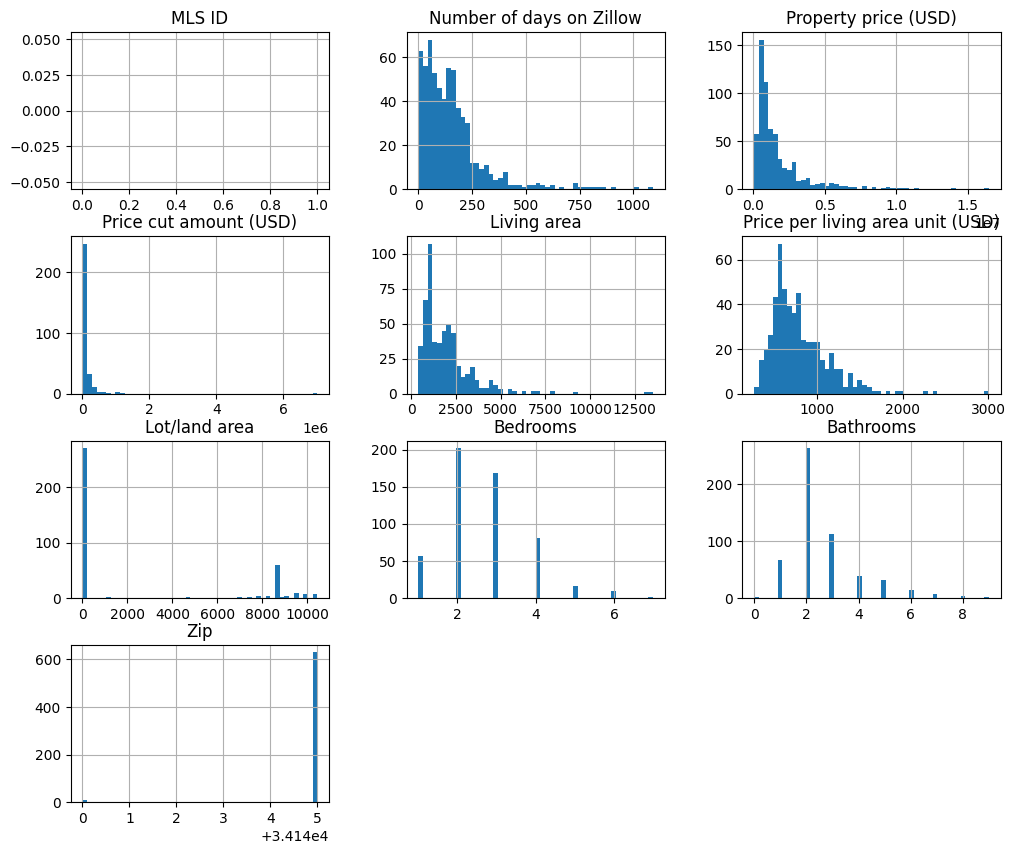

In [9]:
housing.hist(bins = 50, figsize =(12,10))

A lot of the data is right skewed so I will have to adjust for that.

In [10]:
housing.describe()

,MLS ID,Number of days on Zillow,Property price (USD),Price cut amount (USD),Living area,Price per living area unit (USD),Lot/land area,Bedrooms,Bathrooms,Zip
count,0.0,636.000000,6.360000e+02,3.000000e+02,536.000000,536.000000,368.000000,534.000000,539.000000,636.000000
mean,NaN,155.756289,1.710777e+06,1.105627e+05,1962.662313,795.651754,2324.701603,2.681648,2.608534,34144.944969
std,NaN,149.720355,1.915408e+06,4.247613e+05,1464.890280,328.135857,3932.778240,1.073194,1.348551,0.522070
min,NaN,0.000000,6.000000e+04,1.000000e+02,406.000000,271.530000,0.000000,1.000000,0.000000,34140.000000
25%,NaN,56.000000,5.799000e+05,2.000000e+04,1010.000000,568.830000,0.250000,2.000000,2.000000,34145.000000
50%,NaN,127.000000,9.990000e+05,4.500000e+04,1631.000000,725.145000,0.340000,3.000000,2.000000,34145.000000
75%,NaN,198.000000,1.999000e+06,1.000000e+05,2378.750000,960.887500,7514.100000,3.000000,3.000000,34145.000000
max,NaN,1092.000000,1.650000e+07,7.010000e+06,13528.000000,3007.360000,10454.400000,7.000000,9.000000,34145.000000


There is a huge difference in ther scale of values, meanign these will have to be transformed.

In [11]:
housing_zip = housing[housing['Zip'] == 34140] 
housing_zip.describe()

,MLS ID,Number of days on Zillow,Property price (USD),Price cut amount (USD),Living area,Price per living area unit (USD),Lot/land area,Bedrooms,Bathrooms,Zip
count,0.0,7.000000,7.000000e+00,4.000000,6.000000,6.00000,4.000000,6.000000,6.000000,7.0
mean,NaN,139.857143,1.023843e+06,43500.000000,1893.500000,570.62000,6860.700000,2.666667,2.166667,34140.0
std,NaN,72.836412,3.821836e+05,42217.689815,448.773774,119.50385,1482.533952,0.816497,0.752773,0.0
min,NaN,30.000000,6.210000e+05,4000.000000,1477.000000,473.26000,4791.600000,2.000000,1.000000,34140.0
25%,NaN,93.500000,7.240000e+05,16000.000000,1535.750000,494.14250,6425.100000,2.000000,2.000000,34140.0
50%,NaN,164.000000,8.999000e+05,35000.000000,1818.000000,516.37500,7187.400000,2.500000,2.000000,34140.0
75%,NaN,186.500000,1.274500e+06,62500.000000,2070.250000,618.67750,7623.000000,3.000000,2.750000,34140.0
max,NaN,225.000000,1.649000e+06,100000.000000,2652.000000,778.20000,8276.400000,4.000000,3.000000,34140.0


There seems to be quite a diference in values of the whole datatset versus only the ones of the second zip code, however that can largely be due to there only bring 7 values in the second zip code. I decided just to leave them as is, since Marco Island has abunch of little islands surrounding it, meaning the ifference in zip code might just be for a couple of those, not really making a difference.

In [12]:
# Lastly, I'll look at the correlations to get a sense of how things are weighted.
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['Property price (USD)'].sort_values(ascending = False)

Property price (USD)                1.000000
Living area                         0.896172
Bathrooms                           0.831630
Price per living area unit (USD)    0.716057
Bedrooms                            0.690911
Price cut amount (USD)              0.197158
Number of days on Zillow            0.066223
Zip                                 0.037863
Lot/land area                      -0.107320
MLS ID                                   NaN
Name: Property price (USD), dtype: float64

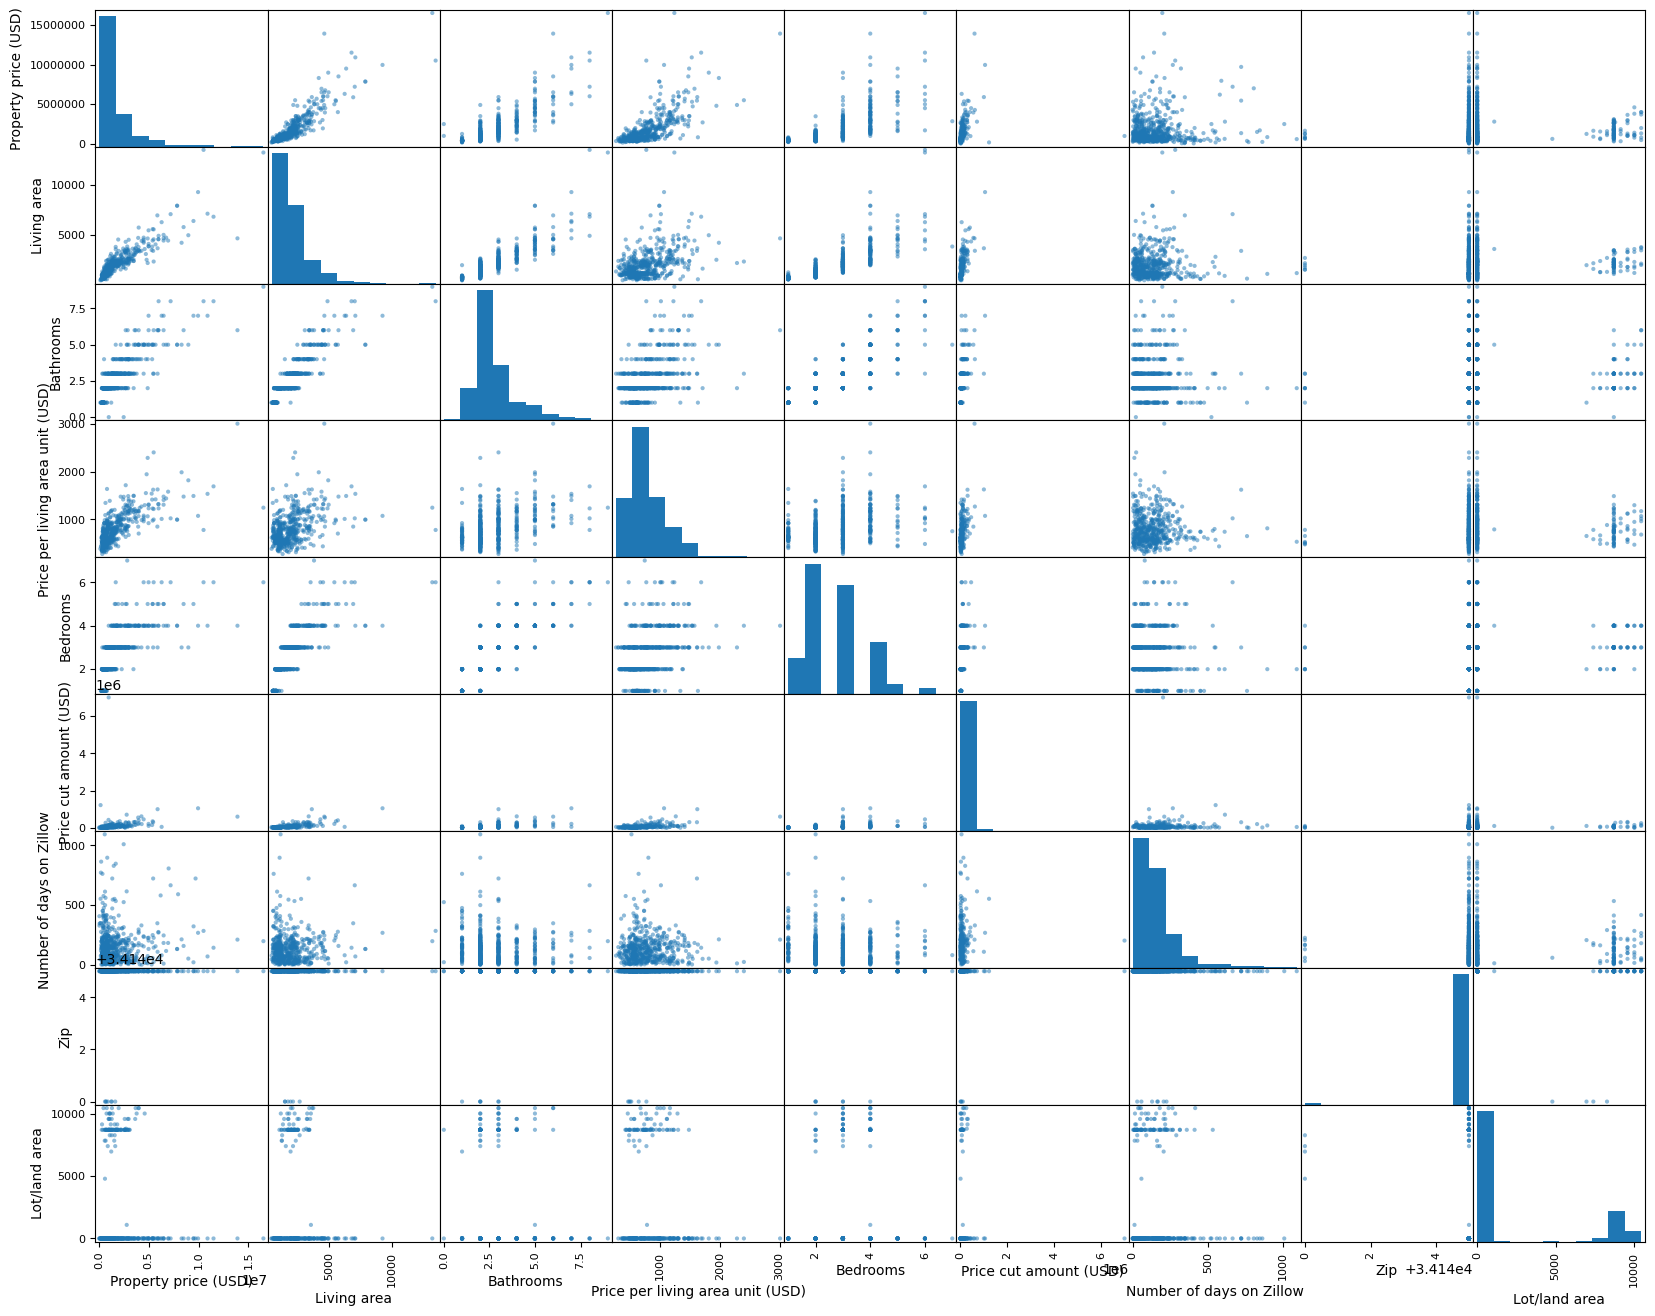

In [13]:
# Visulaizing the correlation
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
attributes = ["Property price (USD)", "Living area", "Bathrooms", "Price per living area unit (USD)", "Bedrooms", "Price cut amount (USD)", "Number of days on Zillow", "Zip", "Lot/land area",]
scatter_matrix(housing[attributes], figsize=(20,16))
plt.show()

<Axes: >

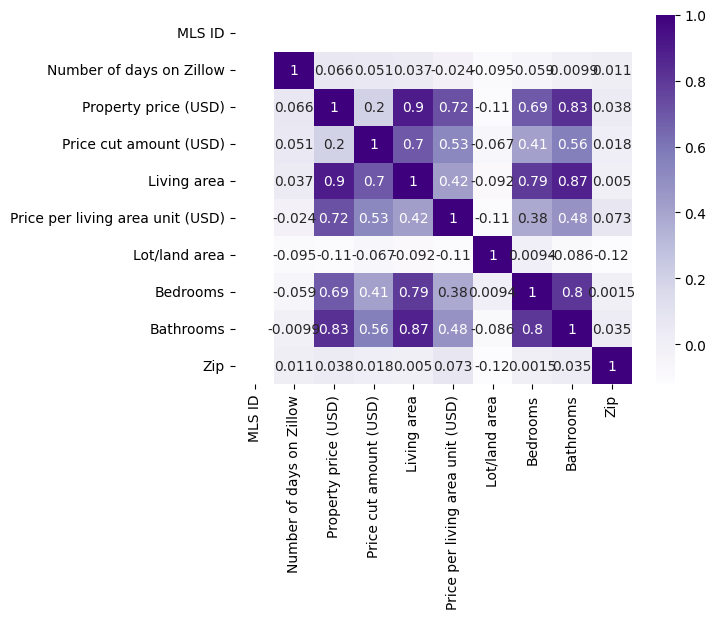

In [14]:
import seaborn as sb

sb.heatmap(corr_matrix, cmap="Purples", annot=True)

# 4.Prepare the Data


Apply any data transformations and explain what and why


In [15]:
# The first thing I'm going to do is drop the lots since those aren't houses
housing = housing[housing['Property type'] != "Lot/Land"]
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 537 entries, 0 to 617
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Property URL                      537 non-null    object 
 1   MLS ID                            0 non-null      float64
 2   Listing description               537 non-null    object 
 3   Property type                     537 non-null    object 
 4   Number of days on Zillow          537 non-null    int64  
 5   Property price (USD)              537 non-null    int64  
 6   Price was cut                     537 non-null    object 
 7   Price cut amount (USD)            259 non-null    float64
 8   Price cut date (MM/DD/YYYY)       259 non-null    object 
 9   Living area                       536 non-null    float64
 10  Living area unit                  536 non-null    object 
 11  Price per living area unit (USD)  536 non-null    float64
 12  Lot/land area

In [16]:
# Dropping the 3 properties without bedroom count and the one without living area
housing.dropna(subset=['Bedrooms'], inplace=True)
housing.dropna(subset=['Living area'], inplace=True)

In [17]:
# Converting Lot/land area to sqft
housing.loc[housing['Lot/land area unit'] == 'acres', 'Lot/land area'] *= 43560
housing.loc[housing['Lot/land area unit'] == 'acres', 'Lot/land area unit'] = 'sqft'
housing["Lot/land area unit"].value_counts()

Lot/land area unit
sqft    272
Name: count, dtype: int64

In [18]:
# Dropping unesscary data and Price per living area unit (USD)
housing.drop(['Property URL','MLS ID','Listing description','Number of days on Zillow','Price cut date (MM/DD/YYYY)', 'Living area unit', 'Price per living area unit (USD)', 'Lot/land area unit', 'Street address', 'City', 'Zip', 'State', 'Country', 'Number of days on Zillow'], axis=1, inplace=True)
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 533 entries, 0 to 617
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property type           533 non-null    object 
 1   Property price (USD)    533 non-null    int64  
 2   Price was cut           533 non-null    object 
 3   Price cut amount (USD)  257 non-null    float64
 4   Living area             533 non-null    float64
 5   Lot/land area           272 non-null    float64
 6   Bedrooms                533 non-null    float64
 7   Bathrooms               533 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 37.5+ KB


I decided to cut out all the information I will not be using, either becuase of low to no correlation, all values being the same, or in the case of Price per living area unit (USD), leaving it in would be cheating.

In [19]:
# checking correlation again just to see what it looks like now
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['Property price (USD)'].sort_values(ascending = False)

Property price (USD)      1.000000
Living area               0.895896
Bathrooms                 0.837525
Price cut amount (USD)    0.766051
Bedrooms                  0.691131
Lot/land area             0.230404
Name: Property price (USD), dtype: float64

In [20]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 533 entries, 0 to 617
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property type           533 non-null    object 
 1   Property price (USD)    533 non-null    int64  
 2   Price was cut           533 non-null    object 
 3   Price cut amount (USD)  257 non-null    float64
 4   Living area             533 non-null    float64
 5   Lot/land area           272 non-null    float64
 6   Bedrooms                533 non-null    float64
 7   Bathrooms               533 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 37.5+ KB


In [21]:
housing.describe()

,Property price (USD),Price cut amount (USD),Living area,Lot/land area,Bedrooms,Bathrooms
count,5.330000e+02,2.570000e+02,533.000000,272.000000,533.000000,533.000000
mean,1.773098e+06,8.197200e+04,1971.183865,11397.218382,2.681051,2.626642
std,1.935316e+06,1.279411e+05,1464.576855,25433.431908,1.074113,1.341011
min,2.150000e+05,1.000000e+03,494.000000,0.000000,1.000000,1.000000
25%,6.150000e+05,2.000000e+04,1023.000000,0.000000,2.000000,2.000000
50%,1.079000e+06,4.090000e+04,1637.000000,9801.000000,3.000000,2.000000
75%,2.200000e+06,1.000000e+05,2390.000000,12196.800000,3.000000,3.000000
max,1.650000e+07,1.050000e+06,13528.000000,393782.400000,7.000000,9.000000


I'm now going to make a pipeline that will do the following with the data:
 - Ordinally encode the categories 'Property type' and 'price was cut' since they could only have two possible values.
 - Use an imputer to fill in the null values for price cut amount and Lot/land are with 0. I was originally going to fill Lot/land area using living area as a refrence, but then made the assumption that if that area wasn't listed on zillow, there most likey is little to no lot area.
 - Transform all the values (except property price) to make sure none have a disproportionately higher impact due to higher scale

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder


numeric_features = ['Price cut amount (USD)', 'Lot/land area', 'Living area', 'Bedrooms', 'Bathrooms']
categorical_features = ['Property type', 'Price was cut']

# Use 0 for any null numeric values and scale all of them
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)), ('std_scaler', StandardScaler())])
# Ordinally encode the two catgorical features
categorical_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])

# Combine transformers
pipeline_house = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)

    ])

# Transform the data
transformed = pipeline_house.fit_transform(housing.drop("Property price (USD)", axis=1))
housing_transformed = pd.DataFrame(transformed, columns=[
     'Price cut amount (USD)', 'Lot/land area', 'Living area', 'Bedrooms', 'Bathrooms', 'Property type', 'Price was cut'])

housing_transformed["Property price (USD)"] = housing["Property price (USD)"].values
housing_transformed.describe()

,Price cut amount (USD),Lot/land area,Living area,Bedrooms,Bathrooms,Property type,Price was cut,Property price (USD)
count,5.330000e+02,5.330000e+02,5.330000e+02,5.330000e+02,5.330000e+02,533.000000,533.000000,5.330000e+02
mean,6.665504e-18,3.332752e-17,-2.666202e-17,1.266446e-16,6.665504e-17,0.405253,0.482176,1.773098e+06
std,1.000939e+00,1.000939e+00,1.000939e+00,1.000939e+00,1.000939e+00,0.491402,0.500152,1.935316e+06
min,-4.046727e-01,-3.059678e-01,-1.009555e+00,-1.566529e+00,-1.214136e+00,0.000000,0.000000,2.150000e+05
25%,-4.046727e-01,-3.059678e-01,-6.480197e-01,-6.346542e-01,-4.677293e-01,0.000000,0.000000,6.150000e+05
50%,-4.046727e-01,-3.059678e-01,-2.283921e-01,2.972210e-01,-4.677293e-01,0.000000,0.000000,1.079000e+06
75%,4.863647e-03,2.210810e-01,2.862326e-01,2.972210e-01,2.786770e-01,1.000000,1.000000,2.200000e+06
max,1.034566e+01,2.040934e+01,7.898304e+00,4.024722e+00,4.757115e+00,1.000000,1.000000,1.650000e+07


In [23]:
# checking correlation again just to see what it looks like now
corr_matrix = housing_transformed.corr(numeric_only=True)
corr_matrix['Property price (USD)'].sort_values(ascending = False)

Property price (USD)      1.000000
Living area               0.895896
Bathrooms                 0.837525
Bedrooms                  0.691131
Property type             0.470210
Price cut amount (USD)    0.303252
Lot/land area             0.280048
Price was cut            -0.166505
Name: Property price (USD), dtype: float64

The last thing I'm going to do is split the data into a training and testing set

In [24]:
housing_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price cut amount (USD)  533 non-null    float64
 1   Lot/land area           533 non-null    float64
 2   Living area             533 non-null    float64
 3   Bedrooms                533 non-null    float64
 4   Bathrooms               533 non-null    float64
 5   Property type           533 non-null    float64
 6   Price was cut           533 non-null    float64
 7   Property price (USD)    533 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 33.4 KB


In [25]:
from sklearn.model_selection import train_test_split
# creating feature variables 
X = housing_transformed.drop('Property price (USD)',axis= 1) 
y = housing_transformed['Property price (USD)']

# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


I am planning to try out a linear regresion model first. I will grade the models based offf RSME.

In [26]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

In [27]:
# creating a regression model 
lin_reg_model = LinearRegression()
# fitting the model 
lin_reg_model.fit(X_train,y_train)

LinearRegression()

In [28]:
# making predictions 
predictions = lin_reg_model.predict(X_test)
predictions_train = lin_reg_model.predict(X_train)

print('Training Values')
print('mean_squared_error: ', root_mean_squared_error(y_train, predictions_train)) 
print('mean_absolute_error: ', mean_absolute_error(y_train, predictions_train))
print('r2_score: ', r2_score(y_train, predictions_train))
# model evaluation 
print('Testing Values')
print('mean_squared_error test: ', root_mean_squared_error(y_test, predictions)) 
print('mean_absolute_error test: ', mean_absolute_error(y_test, predictions))
print('r2_score test: ', r2_score(y_test, predictions))

Training Values
mean_squared_error:  693630.0120824546
mean_absolute_error:  469308.13940396835
r2_score:  0.8591522202236026
Testing Values
mean_squared_error test:  1305393.4751133935
mean_absolute_error test:  617321.9162684475
r2_score test:  0.6601869500791886


I see that this model is doing a lot better with the training set as compared to the testing. If I choose to go ahead with this model I will have to do some regularization to counteract this.

The next thing I'm going to try is random forest.

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [30]:
# creating a random forest model
rf_model = RandomForestRegressor(random_state=20)
# fitting the model 
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=20)

In [31]:
# making predictions 
forest_pred = rf_model.predict(X_test)
forest_pred_train = rf_model.predict(X_train)
print('Training Values')
print('mean_squared_error: ', root_mean_squared_error(y_train, forest_pred_train)) 
print('mean_absolute_error: ', mean_absolute_error(y_train, forest_pred_train))
print('r2_score: ', r2_score(y_train, forest_pred_train))
# model evaluation
print('Testing Values')
print('mean_squared_error test: ', root_mean_squared_error(y_test, forest_pred)) 
print('mean_absolute_error test: ', mean_absolute_error(y_test, forest_pred))
print('r2_score test: ', r2_score(y_test, forest_pred))

Training Values
mean_squared_error:  323722.1188440041
mean_absolute_error:  181066.24826853327
r2_score:  0.9693211552219413
Testing Values
mean_squared_error test:  995669.6144141175
mean_absolute_error test:  471076.30033302517
r2_score test:  0.8023086417407115


In [32]:
from sklearn.model_selection import cross_val_score
pd.Series(-cross_val_score(rf_model, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 10)).describe()

count    1.000000e+01
mean     8.280997e+05
std      2.173223e+05
min      4.428610e+05
25%      6.855294e+05
50%      8.424259e+05
75%      9.498916e+05
max      1.228908e+06
dtype: float64

This one is a lot better but it grealy overfits.

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

# initialize and train the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [34]:
# making predictions 
gbr_pred = gbr_model.predict(X_test)
gbr_pred_train = gbr_model.predict(X_train)
print('Training Values')
print('mean_squared_error: ', root_mean_squared_error(y_train, gbr_pred_train)) 
print('mean_absolute_error: ', mean_absolute_error(y_train, gbr_pred_train))
print('r2_score: ', r2_score(y_train, gbr_pred_train))
# model evaluation
print('Testing Values')
print('mean_squared_error test: ', root_mean_squared_error(y_test, gbr_pred)) 
print('mean_absolute_error test: ', mean_absolute_error(y_test, gbr_pred))
print('r2_score test: ', r2_score(y_test, gbr_pred))

Training Values
mean_squared_error:  360034.30222436
mean_absolute_error:  244852.53234600218
r2_score:  0.9620526010051896
Testing Values
mean_squared_error test:  1064537.4236794221
mean_absolute_error test:  496266.75495326
r2_score test:  0.7740152956198603


In [35]:
pd.Series(-cross_val_score(gbr_model, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 10)).describe()

count    1.000000e+01
mean     8.323517e+05
std      2.454010e+05
min      4.027680e+05
25%      6.490875e+05
50%      8.739115e+05
75%      1.007171e+06
max      1.203574e+06
dtype: float64

The Random Forest Regressor worked best by a small margin so I will moving on with that one.

# 6. Fine Tune the Model

With the select model descibe the steps taken to achieve the best results possible


The first thing I'm going to do in this stage is search for hyperparemeters.

In [36]:
# Randomized Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = { 
    'n_estimators': randint(low=1, high = 100), 
    'max_depth': randint(low=1, high = 100), 
    'min_samples_split': randint(low=2, high = 100),
    'min_samples_leaf': randint(low=1, high = 100)
}

In [37]:
# 10 iterations just to see
rand_search_very_low = RandomizedSearchCV(rf_model, param_distributions = param_distribs, n_iter = 10, scoring = 'neg_root_mean_squared_error', random_state = 20)
rand_search_very_low.fit(X_train, y_train)
very_low_model = rand_search_very_low.best_estimator_
y_train_pred_very_low = very_low_model.predict(X_train)

print('mean_squared_error train: ', root_mean_squared_error(y_train, y_train_pred_very_low)) 
print('mean_absolute_error train: ', mean_absolute_error(y_train, y_train_pred_very_low))
print('r2_score train: ', r2_score(y_train, y_train_pred_very_low))

mean_squared_error train:  815382.5423548054
mean_absolute_error train:  415561.5381295994
r2_score train:  0.8053667336339518


In [38]:
# # 1,000 iterations
# rand_search_low = RandomizedSearchCV(rf_model, param_distributions = param_distribs, n_iter = 1000, scoring = 'neg_root_mean_squared_error', random_state = 20)
# rand_search_low.fit(X_train, y_train)
# low_model = rand_search_low.best_estimator_
# rand_search_low.best_params_


In [39]:
# # Saving the model
# import joblib
# joblib.dump(low_model, "marco_island_housing_thousand_iter_model.pkl")

In [40]:
# # 10,000 iterations
# rand_search_high = RandomizedSearchCV(rf_model, param_distributions = param_distribs, n_iter = 10000, scoring = 'neg_root_mean_squared_error', random_state = 20)
# rand_search_high.fit(X_train, y_train)
# rand_search_high.best_params_
# high_model = rand_search_high.best_estimator_

In [41]:
# joblib.dump(high_model, "marco_island_housing_ten_thousand_iter_model.pkl")

In [42]:
import joblib
low_model = joblib.load("marco_island_housing_thousand_iter_model.pkl")
high_model = joblib.load("marco_island_housing_ten_thousand_iter_model.pkl")
y_train_pred_low = low_model.predict(X_train)
y_train_pred_high = high_model.predict(X_train)
y_test_pred_low = low_model.predict(X_test)
y_test_pred_high = high_model.predict(X_test)

print("1,000 iterations model:")
print('mean_squared_error train: ', root_mean_squared_error(y_train, y_train_pred_low)) 
print('mean_absolute_error train: ', mean_absolute_error(y_train, y_train_pred_low))
print('r2_score train: ', r2_score(y_train, y_train_pred_low))
print("")
print('mean_squared_error train: ', root_mean_squared_error(y_test, y_test_pred_low))
print('mean_absolute_error train: ', mean_absolute_error(y_test, y_test_pred_low))
print('r2_score train: ', r2_score(y_test, y_test_pred_low))
print("")
print("")
print("")
print("1,0000 iterations model:")
print('mean_squared_error train: ', root_mean_squared_error(y_train, y_train_pred_high)) 
print('mean_absolute_error train: ', mean_absolute_error(y_train, y_train_pred_high))
print('r2_score train: ', r2_score(y_train, y_train_pred_high))
print("")
print('mean_squared_error train: ', root_mean_squared_error(y_test, y_test_pred_high)) 
print('mean_absolute_error train: ', mean_absolute_error(y_test, y_test_pred_high))
print('r2_score train: ', r2_score(y_test, y_test_pred_high))

1,000 iterations model:
mean_squared_error train:  581826.7650809555
mean_absolute_error train:  302845.6992116939
r2_score train:  0.9008981766836818

mean_squared_error train:  964003.597742699
mean_absolute_error train:  460347.3233343969
r2_score train:  0.8146833300868188



1,0000 iterations model:
mean_squared_error train:  619421.7577188074
mean_absolute_error train:  326107.1499412435
r2_score train:  0.8876773952896503

mean_squared_error train:  946588.3994774153
mean_absolute_error train:  451684.5390743455
r2_score train:  0.8213185230189237


In [43]:
import joblib
from sklearn.pipeline import make_pipeline

final_model = make_pipeline(pipeline_house, high_model)
joblib.dump(final_model, "marco_island_housing_final_model.pkl")

['marco_island_housing_final_model.pkl']

# 7. Present
In a customer facing Document provide summary of findings and detail approach taken


The first thing I did was assess the goal, which was to get the price of a house given its attributes such as the age of the listing, whether the price was cut, the living area, and the number of bedrooms and bathrooms. I decided to use the RSME as my performance measure. I got my data off Zillow through a free online exporter. Looking through the data I found some issues such as missing values, difference in units, and not quite symmetrical visuals, which might be a problem. I dealt with these when processing the data. I dropped all the values that weren't houses, coveted area units and removed all the attributes that either could not be used or had low correlation to the data. This left me with the attributes Price cut amount (USD), Lot/land area, Living area, Bedrooms, Bathrooms, Property Type, and Price was cut. Some of these values weren’t filled in for every house, so I filled them up with 0s in that spot. I also scaled the values so values that tend to be higher or lower didn’t have disproportionate effects. I then looked at the cleaned up data and realized I had to go back and debug some code. Finally, when everything looked right, I split the data into a training and testing set.

Then, I tried 3 different models in order to find the best one to move on with. The first thing I tried was a linear regression which performed poorly on both the training and testing sets. I also tried the random forest regressor which did so much better in both, and the gradient boosting regressor which performed worse than the random forest, but by very little. Since the random forest regressor performed better across performance measures, including the RSME, I moved on with it. Lastly, I used a randomized search function, which chooses the given number of possible hyperparameters, or parameters of the parameters, to try and randomly selects them, outputting the best model. I saved the models given by the 1,000 iteration set and 10,000 iteration set and found out that the former performed better in training while the latter did on testing, so I decided to use the latter. Moving forawrd, I will use testing scores. This is one part that could definitely be improved as my lack of knowledge this time led to me having to run these steps many times and overall inefficiency. Finally I created a function that takes in the needed attributes as parameters and predicts the house price.

Some possible bias includes how I decided whether attributes were important or not.


# 8. Launch the Model System
Define your production run code, This should be self suficent and require only your model pramaters 


In [1]:
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
def infrence(params):
    df = {'Price cut amount (USD)': [params[0]],'Lot/land area': [params[1]],"Living area": [params[2]], "Bedrooms": [params[3]],
          "Bathrooms": [params[4]],"Property type": [params[5]], 'Price was cut': [params[6]]}
    param_df = pd.DataFrame(data=df)
    final_model = joblib.load("marco_island_housing_final_model.pkl")
    results = final_model.predict(param_df)[0]
    return results

In [2]:
print(infrence([100000.0, 8712.0, 2503.0, 3.0, 3.0, 'Single Family', 'Yes']))

1970536.652250066


/opt/tljh/user/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


This is off the real price of 2500000